In [10]:
# ==========================================
# STEP 1: Mount Drive & Load Dataset
# ==========================================

import pandas as pd
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# ------------------------------------------
# Set path to dataset inside Google Drive
# Update folder name if needed
# ------------------------------------------

path = "/content/drive/MyDrive/Postpartum_infection_detection/Dataset - Updated.csv"

# Verify file exists
if os.path.exists(path):
    print("Dataset found.")
else:
    print("Dataset NOT found. Check path.")

# Load dataset
df = pd.read_csv(path)

# ------------------------------------------
# Basic dataset overview
# ------------------------------------------

print("Dataset shape:", df.shape)

print("\nColumns:")
print(df.columns.tolist())

print("\nPreview:")
print(df.head())

# ------------------------------------------
# Inspect key clinical variables
# ------------------------------------------

key_cols = ['Body Temp', 'Heart Rate', 'Risk Level']

for col in key_cols:
    if col in df.columns:
        print(f"\n--- {col} ---")
        print("Unique values (sample):", df[col].dropna().unique()[:10])
        print(df[col].describe())
    else:
        print(f"\nColumn '{col}' not found.")

# ------------------------------------------
# Missing values
# ------------------------------------------

print("\nMissing values:")
print(df[key_cols].isna().sum())

# ------------------------------------------
# Class distribution
# ------------------------------------------

if 'Risk Level' in df.columns:
    print("\nRisk Level distribution:")
    print(df['Risk Level'].value_counts())

Mounted at /content/drive
Dataset found.
Dataset shape: (1205, 12)

Columns:
['Age', 'Systolic BP', 'Diastolic', 'BS', 'Body Temp', 'BMI', 'Previous Complications', 'Preexisting Diabetes', 'Gestational Diabetes', 'Mental Health', 'Heart Rate', 'Risk Level']

Preview:
   Age  Systolic BP  Diastolic   BS  Body Temp   BMI  Previous Complications  \
0   22         90.0       60.0  9.0        100  18.0                     1.0   
1   22        110.0       70.0  7.1         98  20.4                     0.0   
2   27        110.0       70.0  7.5         98  23.0                     1.0   
3   20        100.0       70.0  7.2         98  21.2                     0.0   
4   20         90.0       60.0  7.5         98  19.7                     0.0   

   Preexisting Diabetes  Gestational Diabetes  Mental Health  Heart Rate  \
0                   1.0                     0              1        80.0   
1                   0.0                     0              0        74.0   
2                   0.0

In [11]:
# ==========================================
# STEP 2: Preprocessing & Label Creation
# ==========================================

# Use already loaded dataframe (df)

# ------------------------------------------
# 1) Convert Body Temperature (°F → °C)
# ------------------------------------------

df['temp_c'] = (df['Body Temp'] - 32.0) * 5.0 / 9.0

# ------------------------------------------
# 2) Create binary label from Risk Level
# High = 1 (higher risk), Low = 0
# ------------------------------------------

df = df[df['Risk Level'].notna()].copy()
df['risk_label'] = (df['Risk Level'] == 'High').astype(int)

# ------------------------------------------
# 3) Select features
# ------------------------------------------

features = ['temp_c', 'Heart Rate']
X = df[features]

# Keep rows with complete feature data
mask = X.notna().all(axis=1)
X = X.loc[mask]
y = df.loc[mask, 'risk_label']

# ------------------------------------------
# 4) Dataset summary
# ------------------------------------------

print("Total samples:", len(X))
print("Positive class prevalence:", round(y.mean(), 4))

Total samples: 1186
Positive class prevalence: 0.3988


In [12]:
# ==========================================
# STEP 3: Train/Test split and feature scaling
# ==========================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ------------------------------------------
# 1) Split data into training and testing sets
# Stratified to preserve class distribution
# 80% train, 20% test
# ------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])

# ------------------------------------------
# 2) Scale features
# Important for linear models (e.g., Logistic Regression)
# Random Forest does not strictly require scaling
# ------------------------------------------

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled and ready for modeling")

Train samples: 948
Test samples: 238
✅ Features scaled and ready for modeling


In [13]:
# ==========================================
# STEP 4: Train baseline classifiers
# ==========================================

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# ------------------------------------------
# 1) Logistic Regression (linear, interpretable)
# 'balanced' handles class imbalance
# ------------------------------------------
clf_lr = LogisticRegression(class_weight='balanced', random_state=42)
clf_lr.fit(X_train_scaled, y_train)

# ------------------------------------------
# 2) Random Forest (non-linear ensemble)
# Can capture complex feature interactions
# ------------------------------------------
clf_rf = RandomForestClassifier(
    n_estimators=100, class_weight='balanced', random_state=42
)
clf_rf.fit(X_train_scaled, y_train)

print("✅ Logistic Regression and Random Forest trained")

✅ Logistic Regression and Random Forest trained



=== Evaluation: Logistic Regression ===
              precision    recall  f1-score   support

           0     0.8542    0.8601    0.8571       143
           1     0.7872    0.7789    0.7831        95

    accuracy                         0.8277       238
   macro avg     0.8207    0.8195    0.8201       238
weighted avg     0.8274    0.8277    0.8276       238

ROC-AUC: 0.843


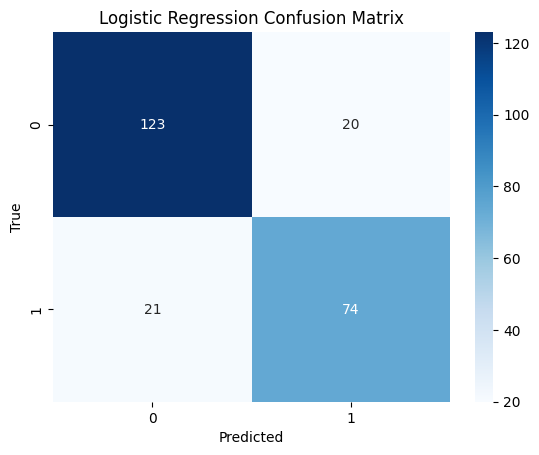


=== Evaluation: Random Forest ===
              precision    recall  f1-score   support

           0     0.8690    0.8811    0.8750       143
           1     0.8172    0.8000    0.8085        95

    accuracy                         0.8487       238
   macro avg     0.8431    0.8406    0.8418       238
weighted avg     0.8483    0.8487    0.8485       238

ROC-AUC: 0.8968


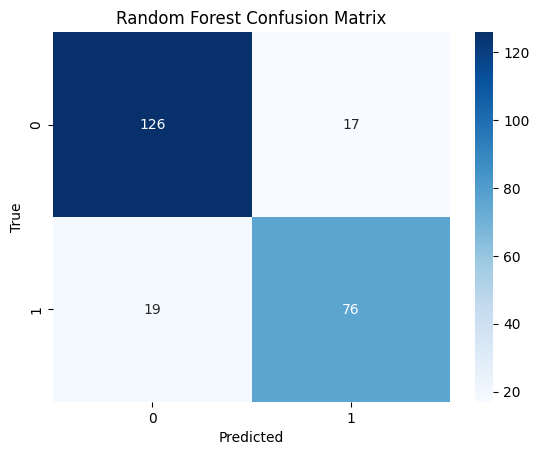

In [14]:
# ==========================================
# STEP 5: Evaluate models (classification metrics + confusion matrix)
# ==========================================

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

def eval_model(model, X_test, y_test, name="Model"):
    """
    Evaluate a classifier:
    - Precision, Recall, F1-score
    - ROC-AUC
    - Confusion Matrix
    """
    # Predictions
    preds = model.predict(X_test)

    # Probabilities for ROC-AUC
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X_test)[:, 1]
    else:
        probs = model.decision_function(X_test)

    # Classification report
    print(f"\n=== Evaluation: {name} ===")
    print(classification_report(y_test, preds, digits=4))
    print("ROC-AUC:", round(roc_auc_score(y_test, probs), 4))

    # Confusion matrix
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(name + " Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# ------------------------------------------
# Evaluate Logistic Regression and Random Forest
# ------------------------------------------
eval_model(clf_lr, X_test_scaled, y_test, "Logistic Regression")
eval_model(clf_rf, X_test_scaled, y_test, "Random Forest")

✅ Best parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 300}
✅ Best CV recall: 0.8201

=== Evaluation: Random Forest (Tuned) ===
              precision    recall  f1-score   support

           0     0.8741    0.8741    0.8741       143
           1     0.8105    0.8105    0.8105        95

    accuracy                         0.8487       238
   macro avg     0.8423    0.8423    0.8423       238
weighted avg     0.8487    0.8487    0.8487       238

ROC-AUC: 0.8944


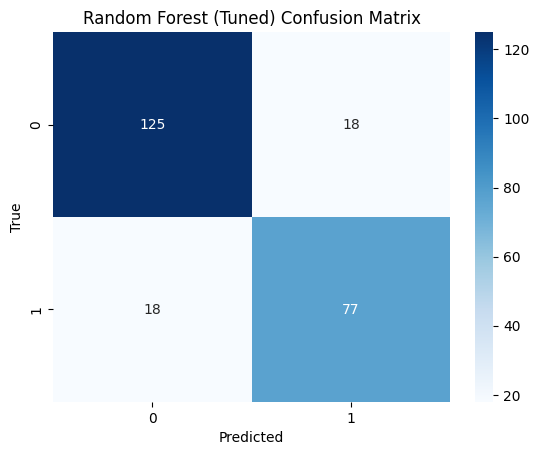

In [15]:
# ==========================================
# STEP 6: Hyperparameter tuning for Random Forest
# ==========================================

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# ------------------------------------------
# Parameter grid for tuning
# ------------------------------------------
param_grid = {
    'n_estimators': [100, 300],       # number of trees
    'max_depth': [None, 8, 16],       # max tree depth
    'min_samples_split': [2, 5]       # min samples to split a node
}

# ------------------------------------------
# GridSearchCV
# - CV=3 for cross-validation
# - Scoring='recall' to prioritize detecting high-risk cases
# - n_jobs=-1 to use all CPU cores
# ------------------------------------------
gs = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42),
    param_grid,
    cv=3,
    scoring='recall',
    n_jobs=-1
)

# Fit GridSearch
gs.fit(X_train_scaled, y_train)

# Best parameters and score
print("✅ Best parameters:", gs.best_params_)
print("✅ Best CV recall:", round(gs.best_score_, 4))

# Save best estimator
best_rf = gs.best_estimator_

# ------------------------------------------
# Evaluate tuned Random Forest on test set
# ------------------------------------------
eval_model(best_rf, X_test_scaled, y_test, "Random Forest (Tuned)")

## Model Comparison and Key Takeaways

We trained two classifiers to predict postpartum infection risk using Heart Rate (HR) and Body Temperature (Temp):

- **Logistic Regression (LR)**: a simple linear model, interpretable and easy to deploy.
- **Random Forest (RF)**: a non-linear ensemble model, tuned using GridSearchCV to optimize recall, prioritizing detection of high-risk cases.

**Evaluation Summary:**

| Model | Accuracy | Precision (1) | Recall (1) | F1-score (1) | ROC-AUC |
|-------|----------|---------------|------------|--------------|---------|
| Logistic Regression | 0.8277 | 0.7872 | 0.7789 | 0.7831 | 0.843 |
| Random Forest | 0.8487 | 0.8172 | 0.8000 | 0.8085 | 0.897 |
| Random Forest (Tuned) | 0.8487 | 0.8105 | 0.8105 | 0.8105 | 0.894 |

**Key Insights:**

- Random Forest slightly outperforms Logistic Regression in accuracy and ROC-AUC.
- Hyperparameter tuning (`n_estimators=300`, `min_samples_split=5`, `max_depth=None`) improved recall, reducing false negatives — critical in healthcare.
- Logistic Regression is sufficient for baseline modeling and provides interpretability.
- Random Forest demonstrates non-linear modeling, useful for more complex datasets with additional features (age, comorbidities, blood pressure, etc.).
- Prioritizing recall ensures high-risk patients are less likely to be missed, which is essential in postpartum infection detection.


In [16]:
# ==========================================
# STEP 7: Create a pipeline and save the model
# ==========================================

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import joblib

# ------------------------------------------
# 1) Create pipeline: scaling + classifier
# ------------------------------------------
logreg_pipe = Pipeline([
    ('scaler', StandardScaler()),                   # automatically scales features
    ('classifier', LogisticRegression(
        class_weight='balanced',                   # handle imbalanced classes
        random_state=42
    ))
])

# ------------------------------------------
# 2) Fit pipeline on raw training data
# (scaling is applied automatically inside pipeline)
# ------------------------------------------
logreg_pipe.fit(X_train, y_train)

# ------------------------------------------
# 3) Save pipeline to file for later use
# ------------------------------------------
joblib.dump(logreg_pipe, "logreg_pipeline.pkl")

print("✅ Logistic Regression pipeline saved successfully!")

✅ Logistic Regression pipeline saved successfully!


In [17]:
# ==========================================
# STEP 8: Create a pipeline for the tuned Random Forest
# ==========================================

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import joblib

# ------------------------------------------
# 1) Pipeline: optional scaling + tuned RF
# Scaling keeps preprocessing consistent with Logistic Regression
# ------------------------------------------
rf_pipe = Pipeline([
    ('scaler', StandardScaler()),  # safe even for tree-based models
    ('classifier', RandomForestClassifier(
        n_estimators=gs.best_params_['n_estimators'],
        max_depth=gs.best_params_['max_depth'],
        min_samples_split=gs.best_params_['min_samples_split'],
        class_weight='balanced',   # handle minority class
        random_state=42
    ))
])

# ------------------------------------------
# 2) Fit pipeline on raw training data
# Scaling is applied automatically inside the pipeline
# ------------------------------------------
rf_pipe.fit(X_train, y_train)

# ------------------------------------------
# 3) Save pipeline to file for later use
# ------------------------------------------
joblib.dump(rf_pipe, "rf_pipeline.pkl")

print("✅ Tuned Random Forest pipeline saved successfully!")


✅ Tuned Random Forest pipeline saved successfully!



=== Logistic Regression Pipeline (Test Set) ===
              precision    recall  f1-score   support

           0     0.8542    0.8601    0.8571       143
           1     0.7872    0.7789    0.7831        95

    accuracy                         0.8277       238
   macro avg     0.8207    0.8195    0.8201       238
weighted avg     0.8274    0.8277    0.8276       238



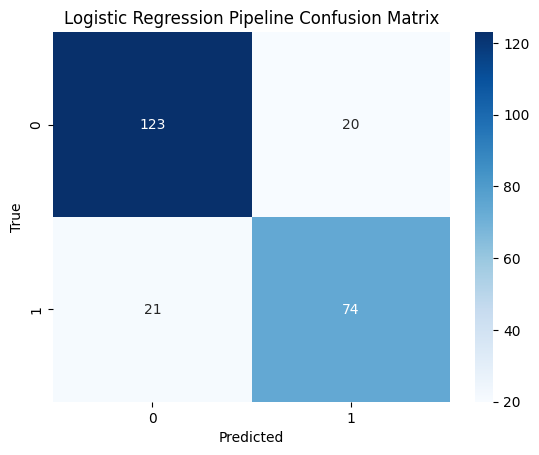


=== Random Forest Pipeline (Test Set) ===
              precision    recall  f1-score   support

           0     0.8741    0.8741    0.8741       143
           1     0.8105    0.8105    0.8105        95

    accuracy                         0.8487       238
   macro avg     0.8423    0.8423    0.8423       238
weighted avg     0.8487    0.8487    0.8487       238



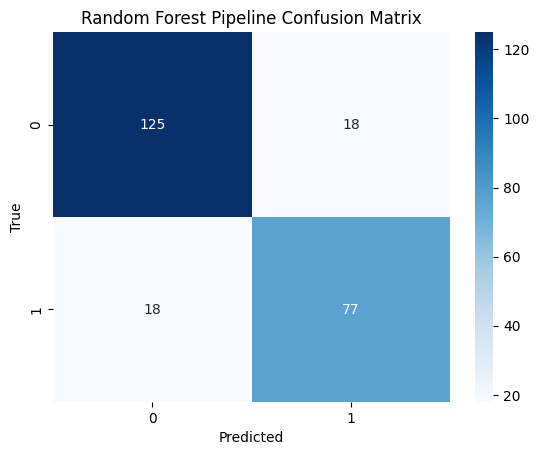

=== Logistic Regression (New Inputs) ===
Predictions: [0 0 1 1 0]
Probabilities: [0.07041774 0.34301303 0.97784236 0.91592828 0.42287115]
=== Random Forest (New Inputs) ===
Predictions: [1 0 1 1 0]
Probabilities: [0.82216207 0.05717433 1.         1.         0.044602  ]


In [18]:
# ==========================================
# STEP 9: Load pipelines, evaluate on test set, and predict new samples
# ==========================================

import joblib
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------------------
# 1) Load saved pipelines
# ------------------------------------------
logreg_pipe = joblib.load("logreg_pipeline.pkl")
rf_pipe = joblib.load("rf_pipeline.pkl")  # optional

# ------------------------------------------
# 2) Evaluate on original test set
# ------------------------------------------
def eval_pipeline(pipe, X_test, y_test, name="Pipeline"):
    preds = pipe.predict(X_test)
    probs = pipe.predict_proba(X_test)[:, 1]  # probability of infection class

    print(f"\n=== {name} (Test Set) ===")
    print(classification_report(y_test, preds, digits=4))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(name + " Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Evaluate both pipelines
eval_pipeline(logreg_pipe, X_test, y_test, "Logistic Regression Pipeline")
eval_pipeline(rf_pipe, X_test, y_test, "Random Forest Pipeline")

# ------------------------------------------
# 3) Test on new patient inputs
# ------------------------------------------
X_new = pd.DataFrame({
    "Heart Rate": [60, 72, 90, 85, 70],
    "temp_c": [36.5, 36.8, 39.0, 38.2, 37.5]
})[X_train.columns]  # ensure column order matches training data

# Predict infection risk
pred_lr = logreg_pipe.predict(X_new)
pred_rf = rf_pipe.predict(X_new)

# Predict probabilities
prob_lr = logreg_pipe.predict_proba(X_new)[:, 1]
prob_rf = rf_pipe.predict_proba(X_new)[:, 1]

# Display predictions
print("=== Logistic Regression (New Inputs) ===")
print("Predictions:", pred_lr)
print("Probabilities:", prob_lr)

print("=== Random Forest (New Inputs) ===")
print("Predictions:", pred_rf)
print("Probabilities:", prob_rf)

In [19]:
import joblib

# Save the trained Logistic Regression pipeline
# Includes preprocessing (scaling) + model
joblib.dump(logreg_pipe, "logreg_pipeline.pkl")

print("✅ Pipeline saved as logreg_pipeline.pkl")

✅ Pipeline saved as logreg_pipeline.pkl
